In [1]:
%config Completer.use_jedi = False

In [41]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.utils import *
from Problem.Congestion_VRP import *
from Problem.GIFGenerator import *
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "UK75_3"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

station_coordinates = pd.read_csv('../datasets/{}/{}_coordinates.csv'.format(dataset[:-2],dataset), encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()
dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
dbf = dbf.to_crs("EPSG:4326")
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000

distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/{}/".format(dataset[:-2]),dataset)

distance_matrix_here = distance_matrix_here.to_numpy()
time_matrix_here = time_matrix_here.to_numpy()

routingContext = RoutingContext(distance_matrix=distance_matrix_here,time_matrix=time_matrix_here,station_coordinates=station_coordinates,station_data=station_data,meta_data=meta_data)
startNodes = {"UK20_1":[0,6,10,15],"UK25":[0,6,10,15],"UK50":[0,6,10,15,21,35,40],"UK75":[0,6,10,15,21,35,40,60,31,68]}
endNodes = {"UK20_1":[4,20,2,5],"UK25":[4,20,2,5,22],"UK50":[4,20,2,5,32,45,1],"UK75":[4,20,2,5,32,45,1]}





In [43]:
startNodeIndeces = startNodes[dataset[:-2]]
endNodeIndeces = endNodes[dataset[:-2]]
locationNodeIndeces = list((set(range(len(points_coordinate))) - set(startNodeIndeces)) - set(endNodeIndeces))

vehicleData = {"emptyWeights":[3000],"maxLoads":[3650],"fuelEmpty":[12],"fuelFull":[15]}
vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData,
                                                            routingContext=routingContext)

customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy()
customer_demands[startNodeIndeces+endNodeIndeces] = 0
station_data["Demand(kg)"] = customer_demands
#station_data.iloc[startNodeIndeces+endNodeIndeces,"Demand(kg)"] = 0

translate_dict = {}
for i,x in enumerate(endNodeIndeces):
    translate_dict[x] = 100+i
initial_solution = cheapest_insertion_dict(locationNodeIndeces,vehicles,endNodeIndeces,routingContext)


min_allowed_drivetime_hours = 0

cost_function_dict = {"distance_matrix":distance_matrix_here,"time_matrix":time_matrix_here,
                              "demands":customer_demands,"vehicle_weight":3000,"start_positions":startNodeIndeces,"meta_data":meta_data}

#old_init_sol = create_initial_solution(locationNodeIndeces,vehicles,endNodeIndeces,fuel_consumption_wong,cost_function_dict)

#initial_solution_no_starts =initial_solution_kmeans(locationNodeIndeces,endNodeIndeces,points_coordinate,translate_dict)# 
data_model_input_multi_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':2,'objective_labels':['Total Fuel','Total Drive Time'],
                                    'constraint_amount':5,'number_of_cities':routingContext.distance_matrix.shape[0],
                                   'min_drivetime':min_allowed_drivetime_hours}

data_model_input_single_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':1,'objective_labels':['Total Fuel'],
                                    'constraint_amount':5,'number_of_cities':routingContext.distance_matrix.shape[0],
                                    'min_drivetime':min_allowed_drivetime_hours}

problem = VRP(data_model_input_multi_objective)

plot_data_storage_base = {'fitness':[], 'route_distance':[],'fuel_consumption':[],'vehicle_loads':[],'computation_times':[],'vehicle_route_time':[],'violation':[],'paths':[],'distance_to_origin':[]}


In [4]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

parameter_list_NSGAIII = [{"mutation":0.5,"crossover":0.2}]

for index,param in enumerate(parameter_list_NSGAIII):
    plot_data_NSGAIII = deepcopy(plot_data_storage_base)
    for x in range(1):
        
        problem_NSGAIII = VRP(data_model_input_multi_objective)
        problem_NSGAIII.name = "NSGA-III"
        problem_NSGAIII.assignClosestEndPoint = True
        max_evaluations = 5000
        
        algorithm_NSGAIII = NSGAIII(problem=problem_NSGAIII,
                                population_size=10,
                                reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                                mutation= PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations)
                                ,population_evaluator=MultiprocessEvaluator()
                                   )
        performance_observer_NSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=1,params=parameter_list_NSGAIII)
        performance_observer_NSGAIII.maxEpochs= len(parameter_list_NSGAIII) * 10
        performance_observer_NSGAIII.currentEpoch = (index*10) + x

        algorithm_NSGAIII.observable.register(observer=performance_observer_NSGAIII)
        algorithm_NSGAIII.run()
        
        solutions_NSGAIII = algorithm_NSGAIII.get_result()
        front_NSGAIII = get_non_dominated_solutions(solutions_NSGAIII)
        
        store_plot_data(plot_data_NSGAIII,performance_observer_NSGAIII,front_NSGAIII[0])
        
nsga3_numerical_path = get_numerical_path(front_NSGAIII[0].path,vehicles)

Epoch:1 of 10
Evaluations: 5000/5000
Params: {'mutation': 0.5, 'crossover': 0.2} 
IGD:409.2615749279587
Best fitness: 254.8653 --- 320.2167                        
Best total fuel consumption:254.87 
Computing time: 5.53s                        
Average computing speed: 904.95it/s
Current Route:[['V6', 11, 22, 42, 30, 33, 28, 20], ['V0', 16, 27, 31, 8, 7, 44, 37, 2], ['V1', 46, 19, 18, 39, 20], ['V2', 23, 47, 34, 29, 38, 24, 2], ['V4', 36, 17, 25, 13, 14, 50, 26, 2], ['V3', 48, 41, 45], ['V5', 43, 49, 3, 12, 9, 1]]
Flags: []                        
Violation:0
Vehicle amount:7


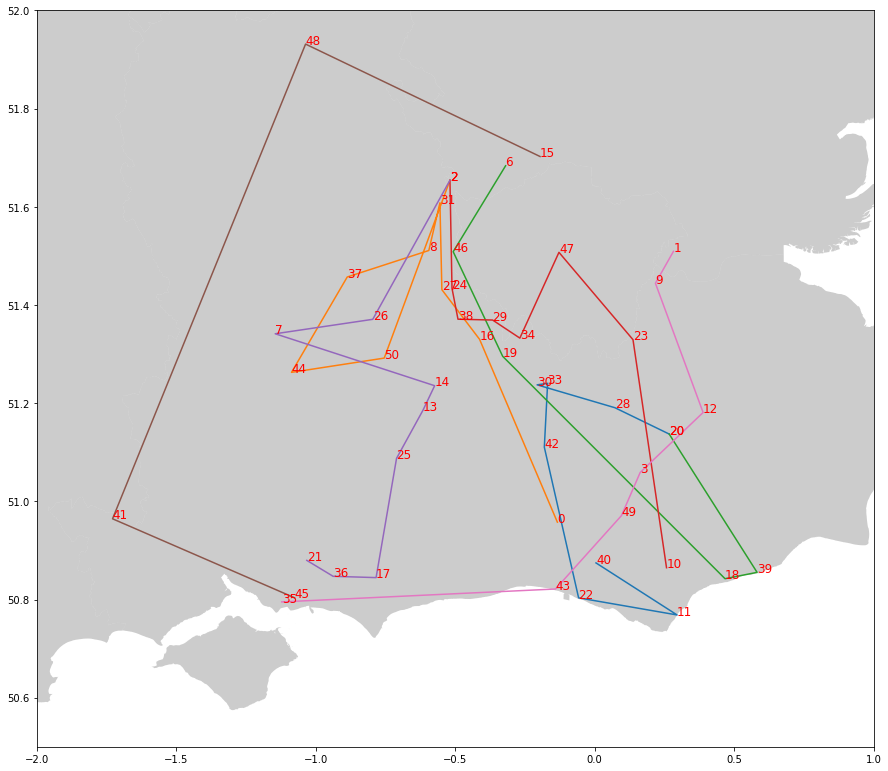

<Figure size 720x720 with 0 Axes>

In [6]:
fig,_ = plot_routes(nsga3_numerical_path,points_coordinate,dbf,station_ids = True, here_api=False, api_key=api)
fig.set_size_inches(15,15)
plt.xlim(-2,1)
plt.ylim(50.5,52)
plt.figure(figsize=(10,10))
plt.show()


In [22]:
def create_congestion(vehicle_paths,vehicles):
    
    numerical_paths = get_numerical_path(vehicle_paths,vehicles)
    paths_sorted_length = sorted(numerical_paths,key=lambda x: len(x),reverse=True)
    longest_path = paths_sorted_length[0]
    longest_path_length = len(longest_path)
    congestion_point = random.randint(1,longest_path_length - 2)
    congestion_edge = (longest_path[congestion_point-1],longest_path[congestion_point])
    longest_path_shifted = np.roll(longest_path,-1)
    drivetimes = time_matrix_here[longest_path[:-1],longest_path_shifted[:-1]]
    congestion_time = np.cumsum(drivetimes)[congestion_point]
    congestion_time
    locked_paths = {}
    for path in vehicle_paths:

        locked_paths[path[0]] = [path[0]]
        vehicle_index = [vehicles[path[0]]["startPos"]]
        numerical_route = vehicle_index +  path[1:]
        numerical_route_shifted = np.roll(numerical_route,-1)

        drive_times = time_matrix_here[numerical_route,numerical_route_shifted]
        drive_times[-1] = 0
        drive_times_cumul = np.cumsum(drive_times)
        test = len(list(filter(lambda x: x < congestion_time, drive_times_cumul)))

        edge_drive_times = list(zip(numerical_route,drive_times_cumul))
        locked_paths[path[0]].extend(path[1:test])

    unused_vehicles = list(filter(lambda x: not x in locked_paths.keys(),vehicles.keys()))
    for unused_vehicle in unused_vehicles:
        locked_paths[unused_vehicle] = [unused_vehicle]

    for index,vehicle in enumerate(locked_paths):

        if locked_paths[vehicle][-1] in endNodeIndeces:
            locked_paths[vehicle].pop()

    current_sol = [x if not x in endNodeIndeces else -1 - index for index, x in enumerate(list(chain(*vehicle_paths)))]
    locked_pickups = list(filter(lambda x: type(x) != str and not x in endNodeIndeces,chain(*locked_paths.values())))

    return congestion_edge,locked_pickups,current_sol,locked_paths
 

In [27]:
congestion_edge, locked_pickups,current_sol,locked_paths = create_congestion(front_NSGAIII[0].path,vehicles)
congestion_edge

(37, 44)

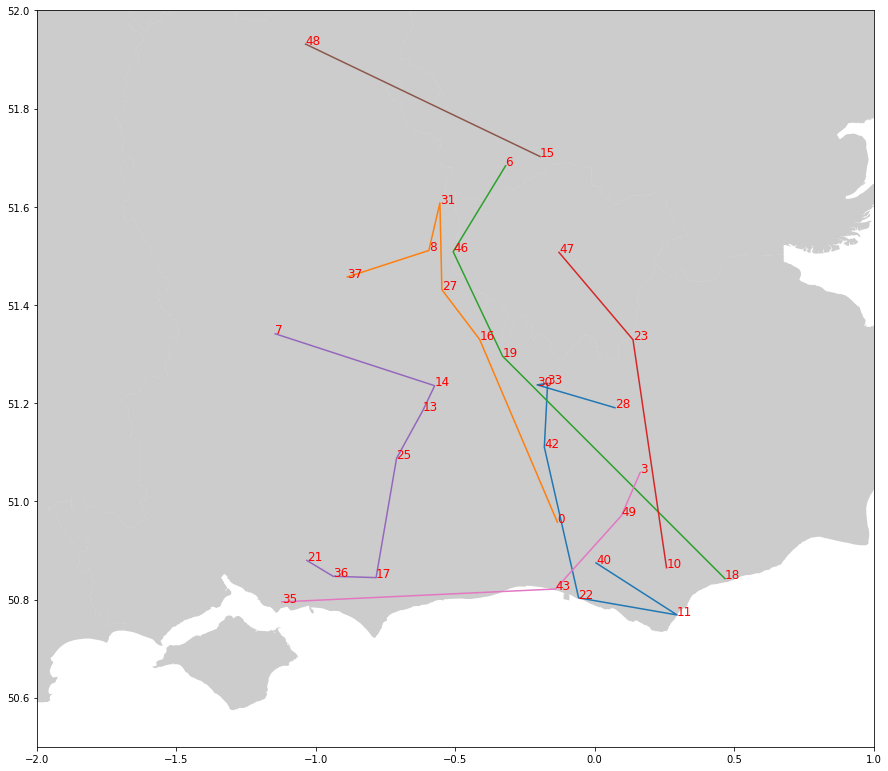

In [28]:

fig,_ = plot_routes(get_numerical_path(list(locked_paths.values()),vehicles),points_coordinate,dbf,station_ids = True, here_api=False, api_key=api)
fig.set_size_inches(15,15)
plt.xlim(-2,1)
plt.ylim(50.5,52)

plt.show()


In [37]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

parameter_list_NSGAIII = [{"mutation":0.6,"crossover":0.2}]
plot_data_NSGAIII = deepcopy(plot_data_storage_base)
for index,param in enumerate(parameter_list_NSGAIII):
    
   

    problem_NSGAIII = Congestion_VRP(data_model_input_multi_objective,currentSolution =current_sol,locked_pickup_points=locked_pickups )
    problem_NSGAIII.set_locked_paths(locked_paths)
    problem_NSGAIII.set_congestion(congestion_edge,1*60*60)
    problem_NSGAIII.name = "NSGA-III"
    problem_NSGAIII.assignClosestEndPoint = True
    max_evaluations = 5000

    algorithm_NSGAIII = NSGAIII(problem=problem_NSGAIII,
                            population_size=10,
                            reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                            mutation= PermutationSwapMutation(param["mutation"]),
                            crossover=PMXCrossover(param["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations)
                            ,population_evaluator=MultiprocessEvaluator())
    performance_observer_NSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=1,params=parameter_list_NSGAIII)
    performance_observer_NSGAIII.maxEpochs= len(parameter_list_NSGAIII) 
    performance_observer_NSGAIII.currentEpoch = index

    algorithm_NSGAIII.observable.register(observer=performance_observer_NSGAIII)
    algorithm_NSGAIII.run()

    solutions_NSGAIII = algorithm_NSGAIII.get_result()
    front_NSGAIII_dynamic = get_non_dominated_solutions(solutions_NSGAIII)

    store_plot_data(plot_data_NSGAIII,performance_observer_NSGAIII,front_NSGAIII_dynamic[0])

nsga3_numerical_path_dynamic = get_numerical_path(front_NSGAIII_dynamic[0].path,vehicles)



#get_results(nsga3_numerical_path,problem_NSGAIII.routing_context.distance_matrix,station_data,meta_data,time_matrix_here)

Epoch:1 of 1
Evaluations: 5000/5000
Params: {'mutation': 0.6, 'crossover': 0.2} 
IGD:410.5477413076216
Best fitness: 257.9194 --- 319.4167                        
Best total fuel consumption:257.92 
Computing time: 5.69s                        
Average computing speed: 878.57it/s
Current Route:[['V6', 11, 22, 42, 33, 30, 28, 20], ['V0', 16, 27, 31, 8, 37, 26, 50, 2], ['V1', 46, 19, 18, 39, 20], ['V2', 23, 47, 34, 29, 38, 24, 2], ['V3', 48, 44, 41, 45], ['V4', 36, 17, 25, 13, 14, 7, 45], ['V5', 43, 49, 3, 12, 9, 1]]
Flags: []                        
Violation:0
Vehicle amount:7


In [31]:
color_map = get_vehicle_color_map(vehicles)
generate_routes_gif(performance_observer_NSGAIII,vehicles,points_coordinate,dbf,congestion_edge,color_map,"")

  0%|          | 0/50 [00:00<?, ?it/s]

<Figure size 720x720 with 0 Axes>

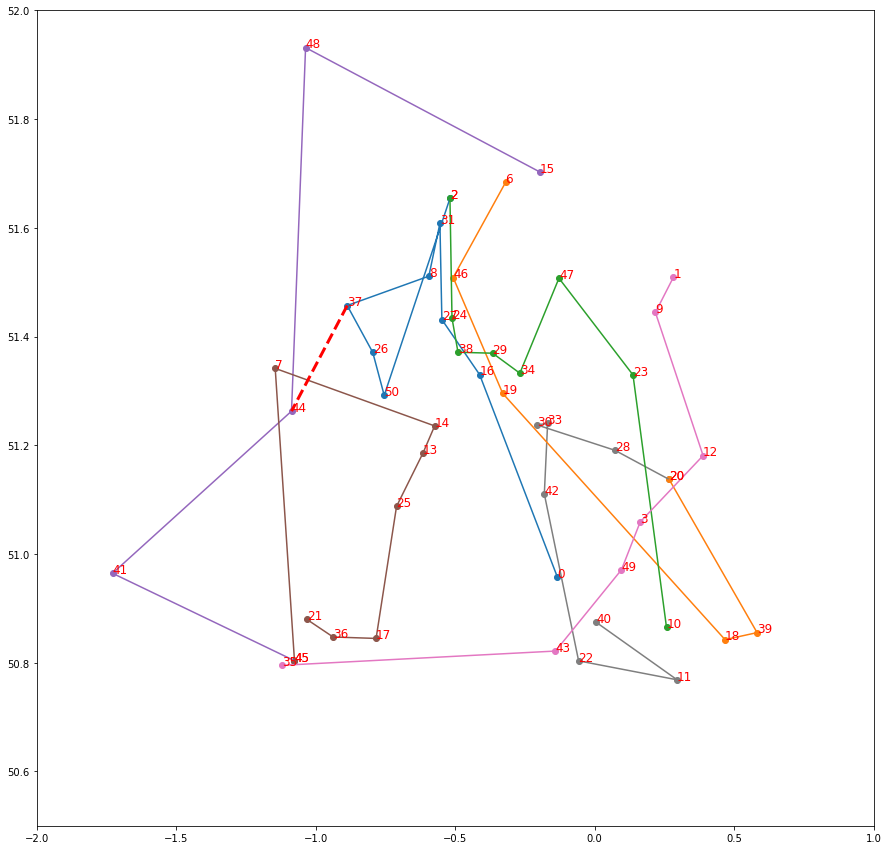

In [39]:

plt.figure(figsize=(10,10))
fig,_ = plot_routes_with_congestion(nsga3_numerical_path_dynamic,points_coordinate,dbf,congestion_edge,colors=color_map,station_ids = True, here_api=False, api_key=api)
fig.set_size_inches(15,15)
plt.xlim(-2,1)
plt.ylim(50.5,52)
# plt.xlim(-3,0)
# plt.ylim(51.5,54)
plt.show()

In [32]:
%matplotlib inline
plt.ioff()
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 100
plots=[]
minx,maxx = np.min(points_coordinate[:,1]),np.max(points_coordinate[:,1])
miny,maxy = np.min(points_coordinate[:,0]),np.max(points_coordinate[:,0])

for index in tqdm(range(len(performance_observer_NSGAIII.path_history))[::10]):
    numerical_path = get_numerical_path(performance_observer_NSGAIII.path_history[index],vehicles)
    
    fig,_ = plot_routes_with_congestion(numerical_path,points_coordinate,dbf,congestion_edge,colors=color_map,station_ids = True, here_api=False, api_key=api)
    fig.set_size_inches(10,10)
    fig.axes[0].set_xlim(-2,1)
    fig.axes[0].set_ylim(50.5,52)
    fig.axes[0].set_title("Fuel Consumption: {} (L)".format(round(performance_observer_NSGAIII.total_consumptions[index],2)),fontsize=20)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plots.append(image)
    plt.close(fig)
    
    


  0%|          | 0/50 [00:00<?, ?it/s]

In [33]:
import imageio 
imageio.mimsave('./tester1.gif', plots, fps=10)